In [1]:
import os    
#os.environ['THEANO_FLAGS'] = "device=gpu1"  
#os.environ["THEANO_FLAGS"] = "mode=FAST_RUN,device=gpu0,floatX=float32,lib.cnmem=1"
os.environ["THEANO_FLAGS"] = "mode=FAST_RUN,device=gpu0,floatX=float32"
import theano


import numpy as np
import matplotlib.pyplot as plt
import random
%matplotlib inline

np.random.seed(13388) # for reproducibility
from sklearn.cross_validation import train_test_split

from keras.models import Sequential
#from keras.layers import containers
from keras.layers import Input, Dense
#from keras.layers.core import AutoEncoder
from keras.activations import sigmoid
from keras.utils import np_utils

from keras.models import Model
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.optimizers import *

nb_classes = 10
#nb_hidden_layers = [3072, 2900, 2300, 1700, 1100, 750, 500, 400, 300, 150, 75, 40]
nb_hidden_layers = [3072, 2048, 1024, 256, 40] 

encoding_dim = 40


Couldn't import dot_parser, loading of dot files will not be possible.


WARNING (theano.sandbox.cuda): The cuda backend is deprecated and will be removed in the next release (v0.10).  Please switch to the gpuarray backend. You can get more information about how to switch at this URL:
 https://github.com/Theano/Theano/wiki/Converting-to-the-new-gpu-back-end%28gpuarray%29

Using gpu device 0: GeForce 920M (CNMeM is disabled, cuDNN not available)
/home/mrafi123/anaconda3/lib/python3.5/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
Using Theano backend.


In [2]:
X_train=np.load('/media/mrafi123/UStore/Dimensionality-Reduction/data/CIFAR10/X_train.npy')
X_test=np.load('/media/mrafi123/UStore/Dimensionality-Reduction/data/CIFAR10/X_test.npy')
y_train=np.load('/media/mrafi123/UStore/Dimensionality-Reduction/data/CIFAR10/y_train.npy')
y_test=np.load('/media/mrafi123/UStore/Dimensionality-Reduction/data/CIFAR10/y_test.npy')

In [3]:
print (X_train.shape)
print (y_train.shape)
print (X_test.shape)
print (y_test.shape)


(50000, 32, 32, 3)
(50000,)
(10000, 32, 32, 3)
(10000,)


In [4]:
# the data, shuffled and split between train and test sets
x_train = X_train.astype('float32') / 255.
x_test = X_test.astype('float32') / 255.
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))

print(x_train.shape, 'train samples')
print(x_test.shape, 'test samples')

# convert class vectors to binary class matrices
Y_train = np_utils.to_categorical(y_train, nb_classes)
Y_test = np_utils.to_categorical(y_test, nb_classes)

print(Y_train.shape, 'train labels')
print(Y_test.shape, 'test labels')

(50000, 3072) train samples
(10000, 3072) test samples
(50000, 10) train labels
(10000, 10) test labels


In [5]:
nfold=5
nb_epoch=50
batch_size=256


In [6]:
# Build the top model to Dimension reduction
input_img = Input(shape=(nb_hidden_layers[0],))
top_encoded = Dense(nb_hidden_layers[1], activation='sigmoid')(input_img)
for i in range(len(nb_hidden_layers) - 2) :

    top_encoded = Dense(nb_hidden_layers[i+2], activation='sigmoid')(top_encoded)
    print('i is ',i)
     
#top_encoded = Dense(nb_hidden_layers[3], activation='sigmoid')(top_encoded)

# add the below line classify
top_decoded = Dense(nb_hidden_layers[0], activation='sigmoid')(top_encoded)
top_autoencoder = Model(input=input_img, output=top_decoded)


i is  0
i is  1
i is  2


In [7]:
print('Top autoencoder model',top_autoencoder.summary())


____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_1 (InputLayer)             (None, 3072)          0                                            
____________________________________________________________________________________________________
dense_1 (Dense)                  (None, 2048)          6293504     input_1[0][0]                    
____________________________________________________________________________________________________
dense_2 (Dense)                  (None, 1024)          2098176     dense_1[0][0]                    
____________________________________________________________________________________________________
dense_3 (Dense)                  (None, 256)           262400      dense_2[0][0]                    
___________________________________________________________________________________________

In [8]:
# this model maps an input to its encoded representation
top_encoder_only = Model(input=input_img, output=top_encoded)
print('Top encoder only model',top_encoder_only.summary())


____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_1 (InputLayer)             (None, 3072)          0                                            
____________________________________________________________________________________________________
dense_1 (Dense)                  (None, 2048)          6293504     input_1[0][0]                    
____________________________________________________________________________________________________
dense_2 (Dense)                  (None, 1024)          2098176     dense_1[0][0]                    
____________________________________________________________________________________________________
dense_3 (Dense)                  (None, 256)           262400      dense_2[0][0]                    
___________________________________________________________________________________________

In [9]:
# create a placeholder for an encoded  input
top_encoded_input = Input(shape=(nb_hidden_layers[-1],))
# retrieve the last layer of the autoencoder model
top_decoder_layer = top_autoencoder.layers[-1]
# create the decoder model
top_decoder_only = Model(input=top_encoded_input, output=top_decoder_layer(top_encoded_input))
print('Top decoder only model',top_decoder_only.summary())


____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_2 (InputLayer)             (None, 40)            0                                            
____________________________________________________________________________________________________
dense_5 (Dense)                  (None, 3072)          125952      input_2[0][0]                    
Total params: 125,952
Trainable params: 125,952
Non-trainable params: 0
____________________________________________________________________________________________________
Top decoder only model None


In [10]:
encoding_dim = 40

kfold_weights_path = os.path.join('cifar10_weights_kfold_' + str(nfold) + 
                                  '_epoch_'+str(nb_epoch)+
                                  '_batch_'+str(batch_size) +
                                  '_encoded_'+str(encoding_dim) +
                                  '.h5')
print(kfold_weights_path)

cifar10_weights_kfold_5_epoch_50_batch_256_encoded_40.h5


In [11]:
random_state=np.random.seed(13398) # for reproducibility

from sklearn.cross_validation import KFold

kf = KFold(len(x_train), n_folds=nfold, shuffle=True, random_state=random_state)
#kf = KFold(len(x_train), n_folds=nfold, shuffle=False, random_state=random_state)
#Shuffle false give very high training loss and very low val loss - indicating unknown fit

print(kf)

sklearn.cross_validation.KFold(n=50000, n_folds=5, shuffle=True, random_state=None)


In [12]:
train_full_encoded_imgs = np.zeros(shape=[x_train.shape[0],encoding_dim])
print(train_full_encoded_imgs.shape)
print(x_test.shape)
test_full_encoded_imgs = np.zeros(shape=[x_test.shape[0],encoding_dim])
test_full_decoded_imgs = np.zeros(shape=[x_test.shape[0],x_test.shape[1]])
print(test_full_encoded_imgs.shape)
print(test_full_decoded_imgs.shape)

(50000, 40)
(10000, 3072)
(10000, 40)
(10000, 3072)


In [13]:
os.path.isfile(kfold_weights_path)

True

In [14]:
# Disable this for avoiding using pretrained weights
#if os.path.isfile(kfold_weights_path):
#autoencoder.load_weights(kfold_weights_path)

In [15]:
print (top_encoder_only)
print (top_decoder_only)

In [ ]:
print(top_autoencoder)

top_autoencoder.compile(optimizer=Adam(lr=1e-3), loss='categorical_crossentropy',metrics=['accuracy'])
score = top_autoencoder.evaluate(x_test, x_test, verbose=0)
print('Test score before fine turning:', score[0])
print('Test accuracy before fine turning:', score[1])

Test score before fine turning: 11757.7432844
Test accuracy before fine turning: 0.0003


In [ ]:
num_fold = 0
restore_from_last_checkpoint=0
for train_index,valid_index in kf:
    s_train,s_valid  = x_train[train_index], x_train[valid_index]
    
    noise_factor = 0.2
    s_train_noisy = s_train + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=s_train.shape) 
    s_valid_noisy = s_valid + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=s_valid.shape) 

    s_train_noisy = np.clip(s_train_noisy, 0., 1.)
    s_valid_noisy = np.clip(s_valid_noisy, 0., 1.)
    #y_train, y_test = y[train_index], y[test_index]
    
    num_fold += 1
    print('\n\nStart KFold number {} from {}'.format(num_fold, nfold))
    print('Split train: ', len(s_train_noisy), len(s_train))
    print('Split valid: ', len(s_valid_noisy), len(s_valid))

    if not os.path.isfile(kfold_weights_path) or restore_from_last_checkpoint == 0:
        
        callbacks = [
                    EarlyStopping(monitor='val_loss', patience=2, verbose=0),
                    ModelCheckpoint(kfold_weights_path, monitor='val_loss', save_best_only=True, verbose=0),
        ]
        history=top_autoencoder.fit(s_train_noisy, s_train, 
                                    batch_size=batch_size, nb_epoch=nb_epoch,
                                    validation_data=(s_valid_noisy, s_valid),
                                    callbacks=callbacks)

        
    # Store train predictions
    train_encoded_imgs = top_encoder_only.predict(x_train,verbose=1)
    print(train_encoded_imgs)
    train_full_encoded_imgs = np.add(train_full_encoded_imgs,train_encoded_imgs)

    
    # Store test predictions
    test_encoded_imgs = top_encoder_only.predict(x_test, verbose=1)
    #full_encoded_imgs = np.vstack([full_encoded_imgs,encoded_imgs])
    test_full_encoded_imgs = np.add(test_full_encoded_imgs,test_encoded_imgs)
    #full_encoded_imgs.append(encoded_imgs)
    #print(full_encoded_imgs.shape)
    
    test_decoded_imgs = top_decoder_only.predict(test_encoded_imgs,verbose=1)
    #full_decoded_imgs = np.vstack([full_decoded_imgs,decoded_imgs])
    test_full_decoded_imgs = np.add(test_full_decoded_imgs,test_decoded_imgs)



Start KFold number 1 from 5
Split train:  40000 40000
Split valid:  10000 10000


In [18]:
print(test_full_encoded_imgs.shape)
print(test_full_decoded_imgs.shape)
print(test_full_encoded_imgs[0])
print(test_full_decoded_imgs)


(10000, 40)
(10000, 3072)
[ 2.59502387  0.25418549  1.23138128  3.62503368  2.38265967  3.20700055
  0.95130581  1.9945465   1.18422499  2.06136391  2.7861394   2.39894894
  1.28189412  0.81468887  2.11886939  2.43622479  0.83834318  1.30430755
  1.4628966   1.78605852  0.56206572  1.23382917  1.17760104  1.51001748
  1.38179639  4.23564512  2.09485269  3.24200046  0.83896027  2.44295478
  2.09924313  2.35570511  1.0362948   2.57587716  3.07322174  1.13289216
  0.96184079  3.38402092  1.2804192   1.80555841]
[[ 2.06182414  1.65240356  0.97013602 ...,  1.02815518  1.49548011
   1.98836055]
 [ 2.80663192  2.93452421  2.94025272 ...,  1.91984355  2.02999288
   1.89176312]
 [ 2.7350297   2.79701793  2.89666095 ...,  0.22942282  0.3259594
   0.44130211]
 ..., 
 [ 0.10592135  0.07930312  0.05865328 ...,  0.54631566  0.428108
   0.33204149]
 [ 0.77194527  0.940898    0.66177788 ...,  1.18094502  1.36274932
   0.98288669]
 [ 1.66793221  1.87137833  1.68799224 ...,  1.41351672  1.46758893
   1.

In [19]:
test_res_encoded_imgs = test_full_encoded_imgs/nfold
test_res_decoded_imgs = test_full_decoded_imgs/nfold
print(test_res_encoded_imgs.shape)
print(test_res_decoded_imgs.shape)
print(test_res_encoded_imgs)
print(test_res_decoded_imgs)

(10000, 40)
(10000, 3072)
[[ 0.51900477  0.0508371   0.24627626 ...,  0.67680418  0.25608384
   0.36111168]
 [ 0.19874044  0.23513412  0.47098415 ...,  0.33140072  0.72991668
   0.6207774 ]
 [ 0.2556842   0.22098439  0.33818062 ...,  0.77238373  0.51011031
   0.45445021]
 ..., 
 [ 0.9263099   0.74477235  0.84688556 ...,  0.05365795  0.33792982
   0.69483886]
 [ 0.55510384  0.62209001  0.38536541 ...,  0.32647137  0.45330889
   0.27994851]
 [ 0.18164444  0.08975157  0.1746839  ...,  0.56114274  0.71481924
   0.36375321]]
[[ 0.41236483  0.33048071  0.1940272  ...,  0.20563104  0.29909602
   0.39767211]
 [ 0.56132638  0.58690484  0.58805054 ...,  0.38396871  0.40599858
   0.37835262]
 [ 0.54700594  0.55940359  0.57933219 ...,  0.04588456  0.06519188
   0.08826042]
 ..., 
 [ 0.02118427  0.01586062  0.01173066 ...,  0.10926313  0.0856216
   0.0664083 ]
 [ 0.15438905  0.1881796   0.13235558 ...,  0.236189    0.27254986
   0.19657734]
 [ 0.33358644  0.37427567  0.33759845 ...,  0.28270334  0.

In [20]:
train_res_encoded_imgs = train_full_encoded_imgs/nfold
print(train_res_encoded_imgs.shape)
print(train_res_encoded_imgs)

(50000, 40)
[[ 0.66889119  0.38634133  0.2929377  ...,  0.48119604  0.48142412
   0.23941585]
 [ 0.27921797  0.27934732  0.21620802 ...,  0.48263147  0.4706046
   0.45153154]
 [ 0.14525253  0.11295465  0.57295272 ...,  0.55389274  0.5717922
   0.72373415]
 ..., 
 [ 0.10975723  0.37641248  0.36083865 ...,  0.31861314  0.37447943
   0.64679526]
 [ 0.09528522  0.40078834  0.30851237 ...,  0.27444832  0.61075319
   0.35167519]
 [ 0.61236379  0.1141133   0.06442644 ...,  0.22357095  0.42076413
   0.40687158]]


In [ ]:
#score = top_autoencoder.evaluate(x_test, x_test, verbose=0)
#print('Test score after fine turning:', score[0])
#print('Test accuracy after fine turning:', score[1])

dict_keys(['val_acc', 'acc', 'val_loss', 'loss'])


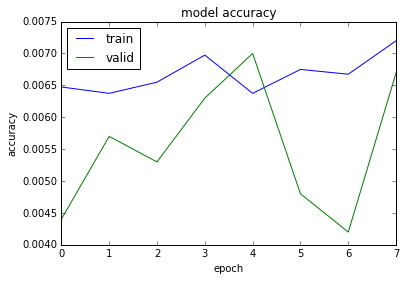

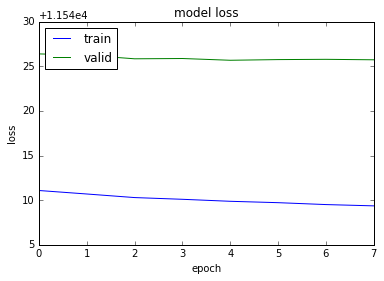

In [21]:
#list all data in history
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='upper left')
plt.show()

In [22]:
from sklearn.neighbors import KNeighborsClassifier
clf = KNeighborsClassifier(n_neighbors=4)
clf = clf.fit(train_res_encoded_imgs, Y_train)

In [23]:
y_pred = clf.predict(test_res_encoded_imgs)

In [26]:
y_pred


array([[ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  1.,  0.],
       [ 0.,  0.,  0., ...,  0.,  1.,  0.],
       ..., 
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.]])

In [27]:
num=len(test_res_encoded_imgs)
r=0
w=0
wrngclassidx=[]
#y_test = np.ravel(y_test)
for i in range(num):
        #print ('y_pred ',y_pred[i])
        #print ('labels ',labels[i])
        #without the use of all() returns error truth value of an array with more than one element is ambiguous
        #if y_pred[i].all() == labels[i].all():
        if np.array_equal(y_pred[i],Y_test[i]):
            r+=1
        else:
            w+=1
            wrngclassidx.append(i)
print ("tested ",  num, "digits")
print ("correct: ", r, "wrong: ", w, "error rate: ", float(w)*100/(r+w), "%")
print ("got correctly ", float(r)*100/(r+w), "%")
print (len(wrngclassidx))

tested  10000 digits
correct:  2349 wrong:  7651 error rate:  76.51 %
got correctly  23.49 %
7651


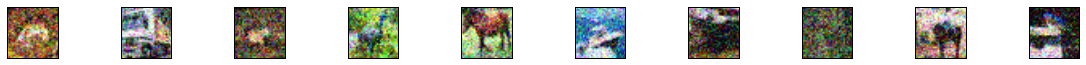

In [28]:
import matplotlib.pyplot as plt
n = 10
plt.figure(figsize=(20, 2))
for i in range(n):
    ax = plt.subplot(2, n, i + 1)
    #ax = plt.subplot(1, n, i)
    plt.imshow(s_train_noisy[i].reshape(32, 32,3))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

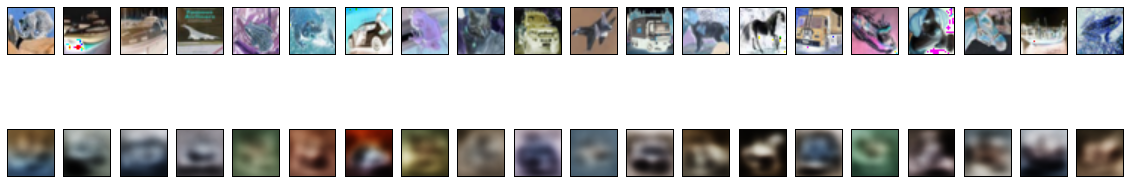

In [29]:

n = 20  # how many digits we will display
plt.figure(figsize=(20, 4))
for i in range(n):
    # display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(X_test[i].reshape(32, 32,3))
    #plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display encoded
    #ax = plt.subplot(2, n, i + 1 + n)
    #plt.imshow(encoded_imgs[i].reshape(6, 6))
    #plt.gray()
    #ax.get_xaxis().set_visible(False)
    #ax.get_yaxis().set_visible(False)
   
    # display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(test_decoded_imgs[i].reshape(32, 32,3))
    #plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

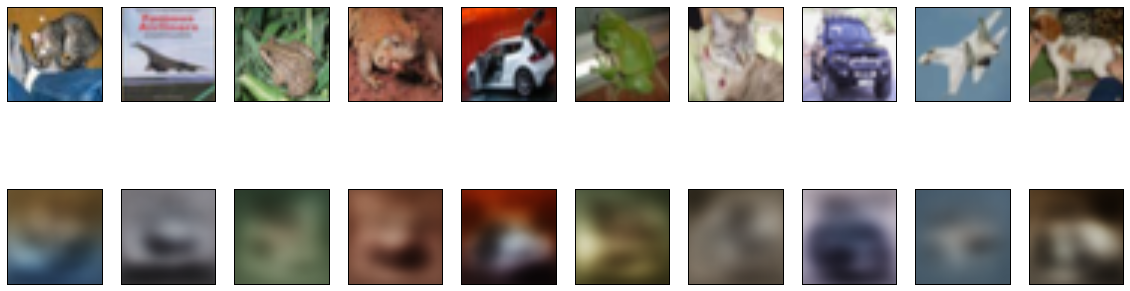

[3, 0, 6, 6, 1, 6, 3, 1, 0, 5]
[array([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.]), array([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.]), array([ 0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.]), array([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.]), array([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.]), array([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.]), array([ 0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.]), array([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.]), array([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.]), array([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.])]


In [30]:
n = 10 
actual=[]
predicted=[]
# how many misclassified digits we will display
i=0
plt.figure(figsize=(20, 6))
for idx in wrngclassidx:
        # display original
        ax = plt.subplot(2, n, i + 1)
        plt.imshow(x_test[idx].reshape(32,32,3))
        actual.append(y_test[idx])
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        # display reconstruction
        ax = plt.subplot(2, n, i + 1 + n)
        plt.imshow(test_res_decoded_imgs[idx].reshape(32,32,3))
        #print(y_pred[idx])
        predicted.append(y_pred[idx])
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        i+=1
        if i==10 :
            break
plt.show()
print (actual)
#print (np.argmax(predicted)) --38
print ((predicted))